# Librerie utilizzate

In [83]:
from matplotlib import pyplot as plt

import matplotlib.dates as md
import numpy as np
from osgeo import gdal
from datetime import datetime
import time
import os
from os import listdir
from os.path import isfile, join,isdir
import rasterio
from rasterio import features,MemoryFile
from rasterio.enums import Resampling
import pprint
import rasterio.mask
import fiona

# Scan and sort the name of files

In [104]:
img_path = join(os.path.abspath(os.getcwd()),"bands","content","data")
scal_path = join(os.path.abspath(os.getcwd()),"sclOrdered")

img_list =[x.split('.')[0] for x in os.listdir(img_path)]
img_list.sort(key=lambda date: datetime.strptime(date, "%Y-%m-%d"))
print("Files and directories in '", img_path, "' :")
 
# prints all files
print(img_list)

print(img_list.index('2017-04-21'))


Files and directories in ' c:\Users\Leo\Desktop\AgriVision2022\bands\content\data ' :
['2016-11-05', '2016-11-05', '2016-11-12', '2016-11-15', '2016-11-22', '2016-11-25', '2016-12-02', '2016-12-05', '2016-12-12', '2016-12-15', '2016-12-22', '2016-12-25', '2017-01-01', '2017-01-04', '2017-01-14', '2017-01-24', '2017-01-31', '2017-02-03', '2017-02-10', '2017-02-13', '2017-02-20', '2017-02-23', '2017-03-02', '2017-03-05', '2017-03-12', '2017-03-15', '2017-03-22', '2017-03-25', '2017-04-01', '2017-04-04', '2017-04-11', '2017-04-14', '2017-04-21', '2017-04-21', '2017-04-24', '2017-05-01', '2017-05-04', '2017-05-11', '2017-05-14', '2017-05-21', '2017-05-24', '2017-05-31', '2017-06-03', '2017-06-10', '2017-06-13', '2017-06-20', '2017-06-23', '2017-06-30', '2017-07-03', '2017-07-08', '2017-07-10', '2017-07-13', '2017-07-15', '2017-07-18', '2017-07-20', '2017-07-23', '2017-07-25', '2017-07-28', '2017-07-30']
32


# Read shape from file

In [124]:
with fiona.open(join(os.path.abspath(os.getcwd()),"campo4","campo 4 totale.shp"), "r") as shapefile:
    print("coordinate system: ")
    print(shapefile.crs)
    campo4Shape = [feature["geometry"] for feature in shapefile]

with fiona.open(join(os.path.abspath(os.getcwd()),"campo6","campo 6 totale.shp"), "r") as shapefile:
    print(shapefile.crs)
    campo6Shape = [feature["geometry"] for feature in shapefile]

with fiona.open(join(os.path.abspath(os.getcwd()),"campo3","campo3.shp"), "r") as shapefile:
    print(shapefile.crs)
    campo3Shape = [feature["geometry"] for feature in shapefile]


coordinate system: 
{'init': 'epsg:32633'}
{'init': 'epsg:32633'}
{'init': 'epsg:32633'}


# Test the validity of image and shape

EPSG:32633
EPSG:32632


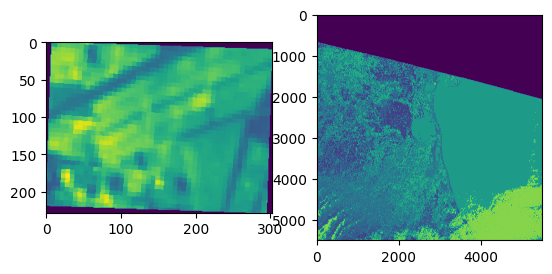

In [97]:
image = rasterio.open(join(img_path,img_list[3]+".tiff"))
print(image.crs)
scl = rasterio.open(join(scal_path,img_list[3]+".jp2"))
print(scl.crs)
shapes32632 = rasterio.warp.transform_geom('EPSG:32633', 'EPSG:32632', campo4Shape, precision=6)
f, axarr = plt.subplots(1,2)
axarr[0].imshow(image.read(1))
axarr[1].imshow(scl.read(1))
outImage, outImageTransf = rasterio.mask.mask(image, campo4Shape, crop=True)
outScl, outSclTransf = rasterio.mask.mask(scl, shapes32632, crop=True)
plt.show()

# Read band file and scl masks

In [128]:

ShapedScl3 = []
ShapedScl4 = []
ShapedScl6 = []

ShapedImage3 = []
ShapedImage4 = []
ShapedImage6 = []

campo3Shape32632 = rasterio.warp.transform_geom('EPSG:32633', 'EPSG:32632', campo3Shape, precision=6)
campo4Shape32632 = rasterio.warp.transform_geom('EPSG:32633', 'EPSG:32632', campo4Shape, precision=6)
campo6Shape32632 = rasterio.warp.transform_geom('EPSG:32633', 'EPSG:32632', campo6Shape, precision=6)

def cutScl(sclBig,shape,field):
    scl, sclTransform = rasterio.mask.mask(sclBig, shape, crop=True)
    scalefactor = [field.shape[1]/scl.shape[1],field.shape[2]/scl.shape[2]]
    outSclMeta = sclBig.meta
    outSclMeta.update({"driver": "GTiff",
                 "height": scl.shape[1],
                 "width": scl.shape[2],
                 "transform": outSclTransf})

    with MemoryFile() as memfile:
        with memfile.open(**outSclMeta) as dataset:  # Open as DatasetWriter
            dataset.write(scl)
        ramTemp = memfile.open()

    return ramTemp.read(
                out_shape=(
                    ramTemp.count, 
                    int(ramTemp.height*scalefactor[0]), 
                    int(ramTemp.width*scalefactor[1])
                    ),
                resampling=Resampling.nearest)[0]

for img in img_list:
    image = rasterio.open(join(img_path,img+".tiff"))
    scl = rasterio.open(join(scal_path,img+".jp2"))

    outImage3, outImageTransf3 = rasterio.mask.mask(image, campo3Shape, crop=True)
    outScl3 = cutScl(scl,campo3Shape32632,outImage3)

    outImage4, outImageTransf4 = rasterio.mask.mask(image, campo4Shape, crop=True)
    outScl4 = cutScl(scl,campo4Shape32632,outImage4)

    outImage6, outImageTransf6 = rasterio.mask.mask(image, campo6Shape, crop=True)
    outScl6 = cutScl(scl,campo6Shape32632,outImage6)

    ShapedImage3.append(outImage3)
    ShapedScl3.append(outScl3)

    ShapedImage4.append(outImage4)
    ShapedScl4.append(outScl4)

    ShapedImage6.append(outImage6)
    ShapedScl6.append(outScl6)
    

ShapedImage3 = np.array(ShapedImage3)
ShapedScl3 = np.array(ShapedScl3)

ShapedImage4 = np.array(ShapedImage4)
ShapedScl4 = np.array(ShapedScl4)

ShapedImage6 = np.array(ShapedImage6)
ShapedScl6 = np.array(ShapedScl6)


RasterioIOError: '/vsimem/f7ad585f-4e50-4cdb-a8eb-3f6dff7f5d6e/f7ad585f-4e50-4cdb-a8eb-3f6dff7f5d6e.tif' not recognized as a supported file format.

# Filter out the bad pixels using the mask

In [127]:
print(ShapedImage3.shape)
print(ShapedScl3.shape)
totalDays = ShapedImage3.shape[0]
totalBands = ShapedImage3.shape[1]
for i in range(0,totalDays):
    Mask3 = (ShapedScl3[i,:,:] == 4) | (ShapedScl3[i,:,:] == 5) | (ShapedScl3[i,:,:] == 6)
    Mask4 = (ShapedScl4[i,:,:] == 4) | (ShapedScl4[i,:,:] == 5) | (ShapedScl4[i,:,:] == 6)
    Mask6 = (ShapedScl6[i,:,:] == 4) | (ShapedScl6[i,:,:] == 5) | (ShapedScl6[i,:,:] == 6)
    for j in range(0,totalBands):
        ShapedImage3[i,j,:,:] = np.ma.masked_array(ShapedImage3[i,j,:,:],Mask3,fill_value=-1)
        ShapedImage4[i,j,:,:] = np.ma.masked_array(ShapedImage4[i,j,:,:],Mask4,fill_value=-1)
        ShapedImage6[i,j,:,:] = np.ma.masked_array(ShapedImage6[i,j,:,:],Mask6,fill_value=-1)

(59, 12, 56, 72)
(59, 56, 72)


[1.8064516129032258, 2.0]
(12, 56, 72)
(1, 31, 36)
(56, 72)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 7 7 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 7 7 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 7 7 7 7 7 7 7 7 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 7 7 7 7 7 7 7 7 7 7 7 7 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

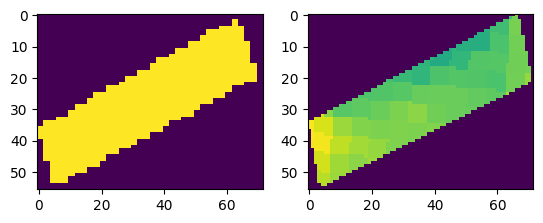

In [81]:
image1 = rasterio.open(r'scl\2016\12\2\0\R20m\SCL.jp2')
image2 = rasterio.open(r'bands\content\data\2016-12-02.tiff')

with fiona.open(join(os.path.abspath(os.getcwd()),"shapeNew","campo3.shp"), "r") as shapefile:
    #EPSG:32632
    campo3Shapes = [feature["geometry"] for feature in shapefile]
    #campo3Shapes = rasterio.warp.transform_geom(shapefile.crs, 'EPSG:32633', campo3Shapes, precision=6)

shapes32633 = rasterio.warp.transform_geom('EPSG:32632', 'EPSG:32633', campo3Shapes, precision=6)
out_image2, out_transform = rasterio.mask.mask(image2, shapes32633, crop=True) #cut the camp


out_image1, out_transform1 = rasterio.mask.mask(image1, campo3Shapes, crop=True) #cut the mask
out_meta = image1.meta
out_meta.update({"driver": "GTiff",
                 "height": out_image1.shape[1],
                 "width": out_image1.shape[2],
                 "transform": out_transform})

scalefactor = [out_image2.shape[1]/out_image1.shape[1],out_image2.shape[2]/out_image1.shape[2]]
print(scalefactor)

with MemoryFile() as memfile:
        with memfile.open(**out_meta) as dataset:  # Open as DatasetWriter
            dataset.write(out_image1)
        ramTemp = memfile.open()

FinalMask = ramTemp.read(
            out_shape=(
                ramTemp.count, 
                int(ramTemp.height*scalefactor[0]), 
                int(ramTemp.width*scalefactor[1])
                ),
            resampling=Resampling.nearest)
print(out_image2.shape) #image of the camp
print(out_image1.shape) #size of the mask
print(FinalMask[0].shape)
print(FinalMask[0])
print(np.unique(FinalMask[0]))
np.savetxt("mask.txt",FinalMask[0])
print(len(FinalMask[0] == 0))
print(len(FinalMask[0] == 7))
filterMask = (FinalMask[0]==4) | (FinalMask[0]==5) | (FinalMask[0]==6)
filtered_res = np.ma.masked_array(out_image2[0],filterMask,fill_value=0)
f, axarr = plt.subplots(1,2)
axarr[0].imshow(FinalMask[0])
axarr[1].imshow(out_image2[0])
plt.show()

